<a href="https://colab.research.google.com/github/Glenn-Matias/fake_news_classifier/blob/main/MP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
print(tf.__version__)
!pip3 install advertools
import advertools as adv
from collections import Counter
import string


2.6.0
     |████████████████████████████████| 275 kB 4.0 MB/s 
     |████████████████████████████████| 254 kB 41.6 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 3.2 MB 28.8 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 3.1 MB 34.1 MB/s 
     |████████████████████████████████| 3.0 MB 49.3 MB/s 
     |████████████████████████████████| 251 kB 46.7 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
  Created wheel for protego: filename=Protego-0.1.16-py3-none-any.whl size=7782 sha256=94d310cffcfc8aaf7d2643c8cfd9e36e129847480c7a3c38aa94e1b51d40b0a5
  Stored in directory: /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-py3-none-any.whl size=11515 sha256=bd42d2b3130a288f482c618ba1876daad40272ababde00a9a7a7bc995575ab0b
  

In [ ]:
!wget --no-check-certificate \
    https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/fakenews/fakenews.zip
!unzip "/content/fakenews.zip" -d "/content/fakenews"

--2021-09-21 02:28:03--  https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/fakenews/fakenews.zip
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.84.98
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.84.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1313458 (1.3M) [application/zip]
Saving to: ‘fakenews.zip’

fakenews.zip        100%[===================>]   1.25M  1.13MB/s    in 1.1s    

2021-09-21 02:28:05 (1.13 MB/s) - ‘fakenews.zip’ saved [1313458/1313458]

Archive:  /content/fakenews.zip
   creating: /content/fakenews/fakenews/
  inflating: /content/fakenews/fakenews/full.csv  


In [ ]:
data = pd.read_csv("./fakenews/fakenews/full.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206 entries, 0 to 3205
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3206 non-null   int64 
 1   article  3206 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.2+ KB


,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [ ]:
# Get counts for the raw text
data['total_words_raw'] = [len(x.split()) for x in data['article'].tolist()]

max_length = data['total_words_raw'].max()
print(max_length)


# Change case to lowercase
data['article'] = data['article'].str.lower()

# Remove the tagalog stop words
data['article_treated'] = data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (adv.stopwords['tagalog'])]))

# Remove symbols and punctuations 
# data['article_treated'] = data['article_treated'].apply(lambda x: ' '.join([word for word in x.split() if word not in string.punctuation]))


# remove special characters !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
def remove_special_characters(input_string):
    for punctuation in string.punctuation:
        input_string = input_string.replace(punctuation, '')
    return input_string

data['article_treated'] = data['article_treated'].apply(remove_special_characters)



# Get counts for the treated text
data['total_words_treated'] = [len(x.split()) for x in data['article_treated'].tolist()]


data.head()

1074


,label,article,total_words_raw,article_treated,total_words_treated
0,0,"ayon sa thewrap.com, naghain ng kaso si krupa,...",257,ayon thewrapcom naghain kaso si krupa 35 noong...,193
1,0,kilala rin ang singer sa pagkumpas ng kanyang ...,153,kilala rin singer pagkumpas kamay tuwing nagta...,115
2,0,"blantyre, malawi (ap) -- bumiyahe patungong ma...",52,blantyre malawi ap bumiyahe patungong malawi ...,40
3,0,"kasama sa programa ang pananalangin, bulaklak ...",65,kasama programa pananalangin bulaklak pagsindi...,42
4,0,linisin ang friendship department dahil dadala...,26,linisin friendship department dadalawin angel ...,19


In [ ]:
print(f"Avg words raw: {data.total_words_raw.sum()/data.shape[0]} ")
print(f"Avg words treated: {data.total_words_treated.sum()/data.shape[0]}")

Avg words raw: 182.72645040548971 
Avg words treated: 121.0068621334997


In [ ]:
##store headlines and labels in respective lists
news = list(data['article_treated'])
labels = list(data['label'])

In [ ]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(news, labels, test_size=0.20, random_state=33)

In [ ]:
print(f"Training set # of rows: {len(training_sentences)}")
print(f"Testing set # of rows: {len(testing_sentences)}")

Training set # of rows: 2564
Testing set # of rows: 642


In [ ]:
training_set_tokenizer = Tokenizer()
training_set_tokenizer.fit_on_texts(training_sentences)
training_vocab_size = len(training_set_tokenizer.word_index) + 1
print(f"Training Set vocabulary size: {training_vocab_size}")

Training Set vocabulary size: 37914


In [ ]:
testing_set_tokenizer = Tokenizer()
testing_set_tokenizer.fit_on_texts(testing_sentences)
testing_vocab_size = len(testing_set_tokenizer.word_index) + 1
print(f"Testing Set vocabulary size: {testing_vocab_size}")

Testing Set vocabulary size: 17566


In [ ]:
##define tokenizing and padding parameters
# vocab_size = 10000 # should be the number of distinct words in the dataset
# max_length = 120 # should be the max length all the training set


max_length = data['total_words_treated'].max()
print(f"Max number of words in a text: {max_length}")


trunc_type='post' # drops the excess sequences at the end of the sequence
padding_type='post' # add zeroesto the end part of the sequence
oov_tok = "<OOV>"


Max number of words in a text: 685


In [ ]:
tokenizer = Tokenizer(num_words=max_length, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

import random
print("Sample tokenized words")
print(dict(random.sample(word_index.items(), 10))) 

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Sample tokenized words
{'makakalaban': 31236, 'sinisipa': 27032, 'maabutan': 37853, 'stamp': 5323, '18580': 18221, 'highschhol': 31598, 'asan': 6640, 'zayn': 29787, 'kalawaan': 29740, 'nalampaso': 20100}


In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
tf.random.set_seed(69)
embedding_dim = 300


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(training_vocab_size, embedding_dim, input_length=max_length),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

##compile the model
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()
checkpoint_path = "training/cp.ckpt"


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 685, 300)          11374200  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 685, 1024)         3330048   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dense_4 (Dense)              (None, 24)                12312     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 17,340,073
Trainable params: 17,340,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2,
                                                 monitor='val_accuracy',
                                                  mode='max',
                                                  save_best_only=True)

# Train the model with the new callback
history = model.fit(training_padded, 
          training_labels,  
          epochs=100,
          validation_data=(testing_padded, testing_labels),
          callbacks=[cp_callback],
          verbose=2)  # Pass callback to training

Epoch 1/100
81/81 - 97s - loss: 0.5739 - accuracy: 0.6798 - val_loss: 0.4089 - val_accuracy: 0.8131

Epoch 00001: val_accuracy improved from -inf to 0.81308, saving model to training/cp.ckpt
Epoch 2/100
81/81 - 90s - loss: 0.3530 - accuracy: 0.8495 - val_loss: 0.2709 - val_accuracy: 0.8972

Epoch 00002: val_accuracy improved from 0.81308 to 0.89720, saving model to training/cp.ckpt
Epoch 3/100
81/81 - 90s - loss: 0.2421 - accuracy: 0.9064 - val_loss: 0.2212 - val_accuracy: 0.9159

Epoch 00003: val_accuracy improved from 0.89720 to 0.91589, saving model to training/cp.ckpt
Epoch 4/100
81/81 - 90s - loss: 0.1902 - accuracy: 0.9376 - val_loss: 0.1808 - val_accuracy: 0.9470

Epoch 00004: val_accuracy improved from 0.91589 to 0.94704, saving model to training/cp.ckpt
Epoch 5/100
81/81 - 90s - loss: 0.1698 - accuracy: 0.9345 - val_loss: 0.2161 - val_accuracy: 0.9190

Epoch 00005: val_accuracy did not improve from 0.94704
Epoch 6/100
81/81 - 90s - loss: 0.1138 - accuracy: 0.9602 - val_loss: 0

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(testing_padded, testing_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

21/21 - 8s - loss: 0.2564 - accuracy: 0.9564
Restored model, accuracy: 95.64%


In [ ]:
from sklearn.metrics import classification_report


sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_seqs = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_pred = model.predict(padded_seqs)
print(y_pred[0:10])

y_pred = [1 if x > 0.5 else 0 for x in y_pred]
print(y_pred[0:10])
print(testing_labels[0:10])

print(classification_report(testing_labels, y_pred))


[[9.9981898e-01]
 [9.9904948e-01]
 [4.9238955e-04]
 [9.9796164e-01]
 [1.8919425e-04]
 [9.9993110e-01]
 [9.9993777e-01]
 [9.9975270e-01]
 [2.4193093e-04]
 [9.9993265e-01]]
[1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
[1 1 0 1 0 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       298
           1       0.98      0.94      0.96       344

    accuracy                           0.96       642
   macro avg       0.96      0.96      0.96       642
weighted avg       0.96      0.96      0.96       642



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Print f1, precision, and recall scores
print(f'Precision: {precision_score(testing_labels, y_pred , average="macro")}')
print(f'Recall: {recall_score(testing_labels, y_pred , average="macro")}')
print(f'f1-score: {f1_score(testing_labels, y_pred , average="macro")}')

Precision: 0.9557400932400932
Recall: 0.9577317777430935
f1-score: 0.9562776669747531


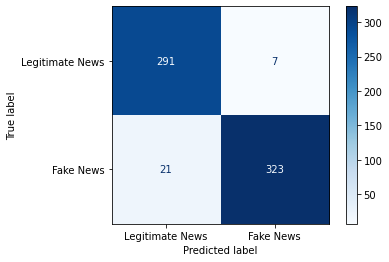

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Legitimate News", "Fake News"]
cm = confusion_matrix(testing_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='')
plt.show()

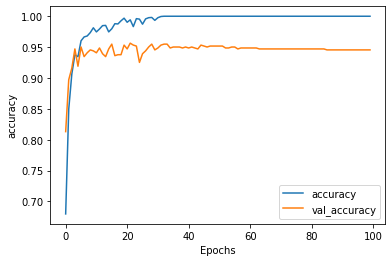

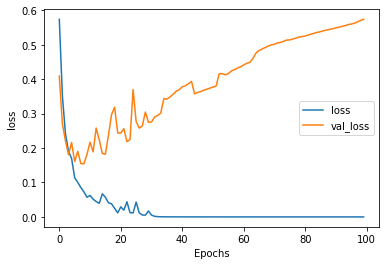

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  
  plt.legend([string, 'val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()


  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")